In [1]:
import pandas as pd
import numpy as np
# pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Context

    Variable	Definition	Key

    Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

*pclass*: A proxy for socio-economic status (SES)

1st = Upper
2nd = Middle
3rd = Lower

*age*: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

*sibsp*: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

*parch*: The dataset defines family relations in this way...

Parent = mother, father
Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
data = pd.read_csv('train.csv', index_col='PassengerId')

In [3]:
data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,S
6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,S
7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,S
8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S


# Data quality assessment

In [4]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [5]:
data.info(memory_usage=False,verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)

In [6]:
data.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

Видим, что есть несколько колонок, где есть пропуски данных, причем в колонке Cabin их значительное количество от общего числа строк.

Однако в зависимости от расположения каюты относительно корабля можно уже сделать некоторые выводы относительно выживаемости их жителей

Так что просто отбросить эту колонку было бы не очень разумно

Сначала я сделаю предварительную очистку и отброшу строки, где больше 90% данных — пропуски

In [37]:
data_lessna = data.dropna(thresh=data.columns.size*0.9)

In [38]:
data_lessna.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          1041
SibSp           0
Parch           0
Ticket         80
Fare           39
Cabin       60999
Embarked       88
dtype: int64

Стало чуть лучше, осталость немного пропусков в колонках Ticket, Fare и Embarked 

In [9]:
data_lessna[['Ticket','Fare','Embarked']].info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93128 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticket    93048 non-null  object 
 1   Fare      93089 non-null  float64
 2   Embarked  93040 non-null  object 
dtypes: float64(1), object(2)

И если колонка с ценой билета(Fare) — числовая и мы можем её эстимировать, например, исходя из социального класса пассажира корабля,

то колонки с пустыми номерами билета (Ticket) и портом посадки(Embarked) мы можем просто отбросить, тем более, что сумммарно их всего около 2% от общего объема имеющихся данных

In [39]:
data_lessna = data_lessna.dropna(subset=["Ticket", "Embarked"])

In [43]:
data_lessna.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          1041
SibSp           0
Parch           0
Ticket          0
Fare           39
Cabin       60999
Embarked        0
dtype: int64

In [64]:
temp = data_lessna.merge(data_lessna.groupby('Pclass').Fare.median(),on='Pclass',how='left',suffixes=('','_r'))

In [73]:
temp.Fare = temp.Fare.where(temp.Fare.notna(),temp.Fare_r)

In [81]:
temp = temp.drop(columns='Fare_r')

In [84]:
temp.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          1041
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin       60999
Embarked        0
dtype: int64

***TODO:
заполнить пустые возраста случайной выборкой из уже имеющихся с учетом частотности***

In [106]:
temp.Age.sample(weights=temp.Age.value_counts())

69    23.0
73    60.0
29    31.0
24    26.0
61    21.0
52    64.0
25    35.0
42    22.0
51    37.0
60    40.0
Name: Age, dtype: float64

In [108]:
data_cleaned = temp.rename(columns=str.lower)

In [110]:
data_cleaned.isna().sum()

survived        0
pclass          0
name            0
sex             0
age          1041
sibsp           0
parch           0
ticket          0
fare            0
cabin       60999
embarked        0
dtype: int64

# Data exploration

Соотношение выживших среди людей разных социальных классов в зависимости от того имеется ли в данных информация о каюте

Нет информации о каюте

In [117]:
(data_cleaned[data_cleaned.cabin.isna()].groupby(['survived','pclass']).size()/len(data_cleaned)*100).unstack()

pclass,1,2,3
survived,,,
0,2.644148,12.708692,28.616609
1,1.355422,12.521515,7.772160


Есть информации о каюте

In [116]:
(data_cleaned[data_cleaned.cabin.notna()].groupby(['survived','pclass']).size()/len(data_cleaned)*100).unstack()

pclass,1,2,3
survived,,,
0,10.935886,1.172547,1.372633
1,17.430077,2.586059,0.884251


In [146]:
data_cleaned['has_cabin'] = data_cleaned.cabin.notna()

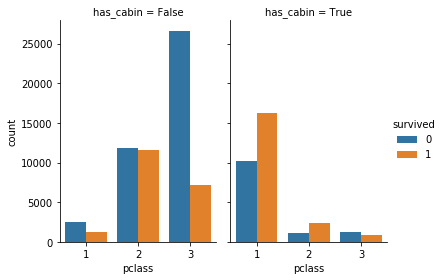

In [147]:
sns.catplot(x="pclass", hue="survived", col="has_cabin",
                data=data_cleaned, kind="count",
                height=4, aspect=.7);

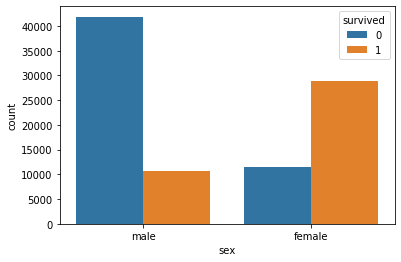

In [149]:
sns.countplot(x='sex', hue='survived', data=data_cleaned)

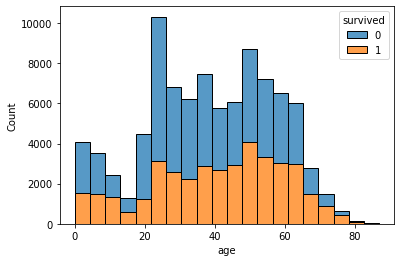

In [154]:
sns.histplot(x='age', hue='survived', data=data_cleaned, bins=20, multiple='stack')

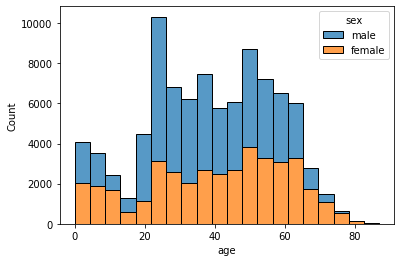

In [155]:
sns.histplot(x='age', hue='sex', data=data_cleaned, bins=20, multiple='stack')

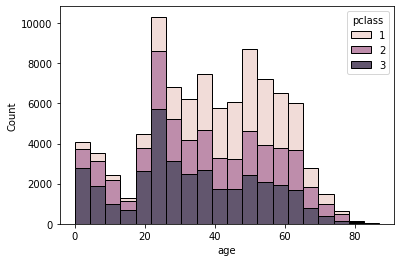

In [156]:
sns.histplot(x='age', hue='pclass', data=data_cleaned, bins=20, multiple='stack')

# Summary